In [3]:
# my modules imports
from model import SEIR
from utils import draw_input_params

# other imports
from pprint import pprint
import numpy as np
from scipy.integrate import RK45, odeint
import matplotlib.pyplot as plt

# bokeh plotting
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
from bokeh.models import Legend
output_notebook(hide_banner=True)

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider


In [4]:
debug = True
seed = 1111

In [5]:
if(debug):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    model.step(dt = 1.0) # dt in days 
    model.prettyprint()

============== SEIR MODEL ==============
----------- input parameters -----------
OrderedDict([('pa', 0.44777459960438104),
             ('pIH', 0.18875055527924495),
             ('pIU', 0.020307202696216567),
             ('pHD', 0.13104769418698442),
             ('pHU', 0.10020098399490976),
             ('pUD', 0.2471189448783151),
             ('NI', 8.951166880633519),
             ('NH', 22.359158732407092),
             ('NU', 14.954680759619642),
             ('R0', 3.2922126744045577),
             ('mu', 0.018855441784553242),
             ('N', 49),
             ('t0', 10),
             ('Im0', 47.1459765189812),
             ('lambda1', 0.0003134189119522501)])
---------------- Rates -----------------
OrderedDict([('gIR', 0.09881985306407182),
             ('gIH', 0.011644610401521123),
             ('gIU', 0.0012528146653254559),
             ('gHD', 0.005861029735302406),
             ('gHU', 0.004481429073164532),
             ('gHR', 0.03438194303365658),
            

In [6]:
ykeys = {
        'S' : 0,
        'Im' : 1,
        'Ip' : 2,
        'Rm' : 3,
        'RI' : 4,
        'H' : 5,
        'U' : 6,
        'RH' : 7,
        'D' : 8,
        'DR' : 9
    }

 
def extract_int_value(solution, step_in_day):
    # start:end:step
    sol, period = (solution[::int(1/step_in_day),:], 1) if step_in_day < 1 else (solution, step_in_day) # extraction of integer day value
    return sol, period # period = 1, if we have a value for each day, if one value every two days, equals 2 etc.

def post_processing(solution, period):
    # order : S, Im, Ip, Rm, RI, H, U, RH, D, DR
    # we suppose that the first element is the 0th day.
    max_it = np.argmax(solution[:,ykeys['U']])
    max_U = solution[max_it,ykeys['U']]
    max_time = max_it*period
    return int(max_time), int(max_U)
    
def plot_solution(seed = None):
    x = draw_input_params(seed)
    t0 = x[-3]
    model = SEIR(x)
    model.prettyprint()
    
    fcn = model.get_fcn()
    y_ini = model.get_state()
    # in number of days
    step_in_day = 0.1 # 1/step_in_day should be an integer
    tini = t0
    tend = 200.0 + t0 # in days
    number_of_steps = int((tend-tini)/step_in_day)
    
    t_simu = np.linspace(tini,tend,number_of_steps)
    
    
    rtol, atol = 1e-3, 1e-6 # default values
    solution = odeint(func = fcn, t = t_simu, y0 = y_ini)  
    sol, period = extract_int_value(solution, step_in_day)
    
    t = np.linspace(tini, tend, int((tend-tini)/period)) # t for printing where 1 day = 1 value.

    max_time, max_U = post_processing(sol, period)
    print('Max intensive care load at days {} with {} patients.'.format(max_time, max_U))

    names = ['Susceptible', 'Infected - Not detected', 'Infected - Detected', 'Recovered - Not detected', \
             'Recovered - Detected - No Hospital', 'In Hospital', 'In Intensive Care', 'Recovered - from Hospital', 'Dead', 'Number of new cases (DR)']
    colors = ['blue', 'orange', 'red', 'cyan', 'green', 'pink', 'purple', 'brown', 'black', 'yellow'] # https://www.geeksforgeeks.org/python-bokeh-colors-class/
    
    fig_sol = figure(x_range=(tini, tend), plot_height=450, plot_width=900, title="Solution")
    
    
    
    legend_it = []
    for idx, name in enumerate(names):
        c = fig_sol.x(t, sol[:,idx], line_width=1, color = colors[idx], alpha=0.9, muted_color=colors[idx], muted_alpha=0.01) # legend_label="Speed")
        legend_it.append((name, [c]))
        
    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    fig_sol.add_layout(legend, 'right')
    #show(column(fig_sol_speed), notebook_handle=True)

    show(fig_sol, notebook_handle=True)
    

In [7]:
plot_solution(seed = 1000)

============== SEIR MODEL ==============
----------- input parameters -----------
OrderedDict([('pa', 0.7267947927323049),
             ('pIH', 0.06725104146866087),
             ('pIU', 0.03850848593047074),
             ('pHD', 0.14821914014279983),
             ('pHU', 0.18724745351820354),
             ('pUD', 0.242466536184544),
             ('NI', 8.162838499076356),
             ('NH', 18.971944613457058),
             ('NU', 12.3313219734838),
             ('R0', 3.3208703621265308),
             ('mu', 0.024495764107072285),
             ('N', 39),
             ('t0', 4),
             ('Im0', 39.823258653075285),
             ('lambda1', 0.0002640308679571459)])
---------------- Rates -----------------
OrderedDict([('gIR', 0.11896669847213927),
             ('gIH', 0.0022508511868136113),
             ('gIU', 0.0012888554491663439),
             ('gHD', 0.00781254337194649),
             ('gHU', 0.009869702728595695),
             ('gHR', 0.03502716352374517),
             ('g

In [8]:
def Monte_Carlo_Umax(N = 100):
    list_U = []
    list_times = []
    
    for k in range(N): 
        x = draw_input_params()
        model = SEIR(x)

        fcn = model.get_fcn()
        y_ini = model.get_state()
        
        step_in_day = 0.1 # 0.1 : 10 points per day
        tini = 0.
        tend = 200.0
        number_of_steps = int((tend-tini)/step_in_day)

        t = np.linspace(tini,tend,number_of_steps)

        rtol, atol = 1e-3, 1e-6 # default values
        
        solution = odeint(func = fcn, t = t, y0 = y_ini)
    
        sol, period = extract_int_value(solution, step_in_day)
        max_time, max_U = post_processing(sol, period)
        list_U.append(max_U)
        list_times.append(max_time)
    
    return np.array(list_U), np.array(list_times)

In [9]:
N=1000
list_U, list_times = Monte_Carlo_Umax(N=N)

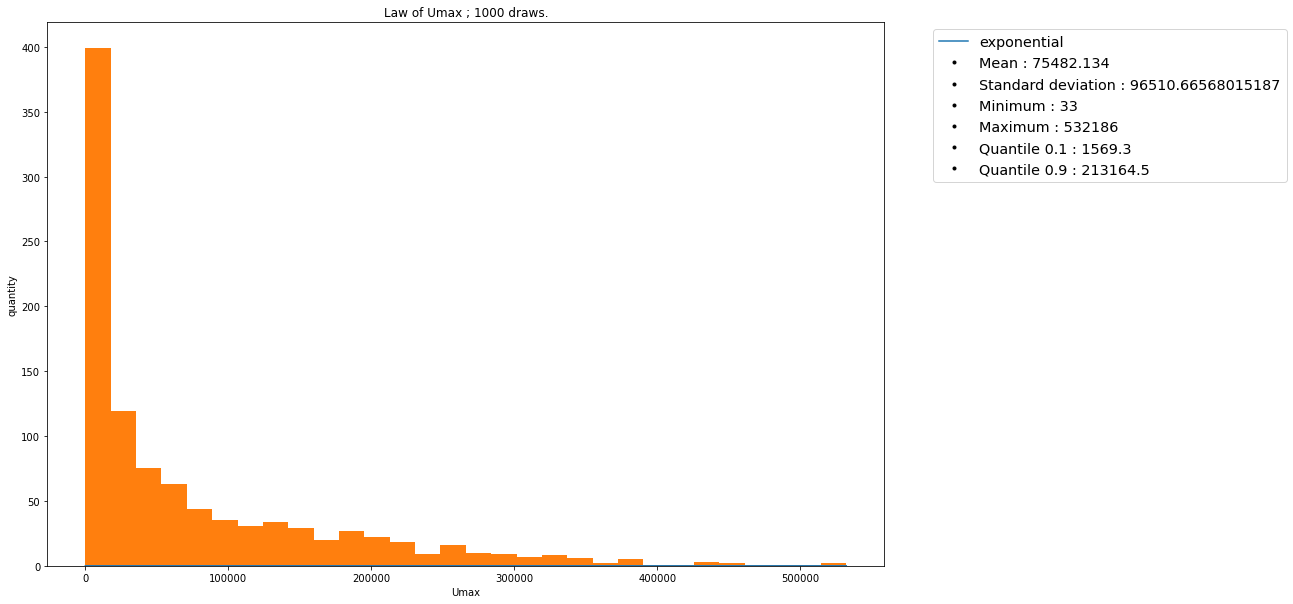

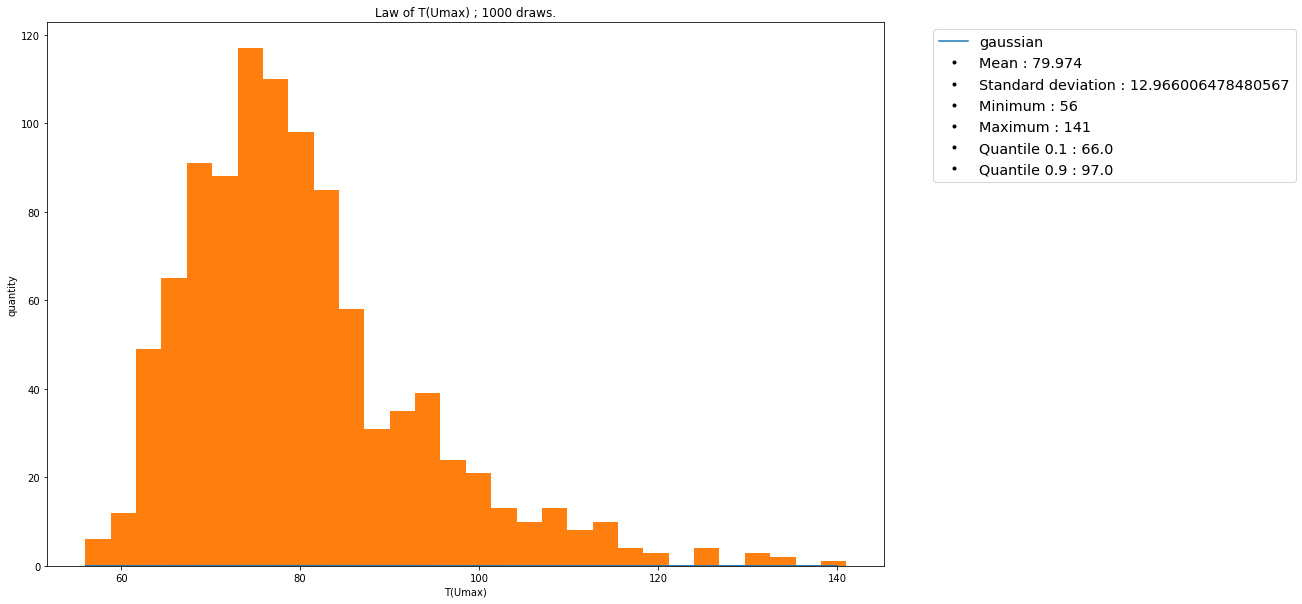

In [10]:
from scipy.stats import chi2, norm, poisson, expon
bins = 30

def get_law(array, bins, name, law = None, name_law = '', savefig = None):
    mean, std = np.mean(array), np.std(array)
    m, M = np.min(array), np.max(array)
    q10, q90 = np.quantile(array, q=0.1),np.quantile(array, q=0.9)
    
    dico = {
        'Mean' : mean,
        'Standard deviation' : std,
        'Minimum' : m,
        'Maximum' : M,
        'Quantile 0.1':q10,
        'Quantile 0.9':q90
    }
    
    N = array.shape[0]
    
    fig, ax = plt.subplots(figsize = (15,10))

    if(law!=None):
        x = np.arange(m, M)
        y = law(x, mean, std) # scale = 1/lambda = Esp(U)
        ax.plot(x,y, label = name_law)
        
    ax.hist(array, bins = bins) # , density = True)
    
    ax.set_title('Law of {} ; {} draws.'.format(name, N), fontsize=12)
    ax.set_xlabel(name, fontsize=10)
    ax.set_ylabel('quantity', fontsize=10)
    
    for key, value in dico.items():
        ax.plot([],[], '.', label = '{} : {}'.format(key, value), color = 'k')
        
    plt.legend(loc='upper left', fontsize='x-large', title_fontsize='x-small', ncol=1, bbox_to_anchor=(1.05, 1))

    if(savefig!=None):
        plt.savefig(savefig+'.png', dpi = 40)
    else:
        plt.show()

gaussian_pdf = lambda x, mean, std : norm.pdf(x=x, loc = mean, scale = std)
exponential_pdf = lambda x, mean, std : expon.pdf(x=x, loc=0, scale=mean) # scale = 1/lambda = Esp(U)
chi2_k1_pdf = lambda x, mean, std : chi2.pdf(x=x, df=1, loc=0, scale=mean) # df : degrees of freedom 
poisson_pmf = lambda x, mean, std : poisson.pmf(x, mu = mean, loc=0)

get_law(list_U, bins = bins, name = 'Umax', law = exponential_pdf, name_law = 'exponential', savefig = 'law_Umax')
get_law(list_times, bins = bins, name = 'T(Umax)', law = gaussian_pdf, name_law = 'gaussian', savefig = 'law_T(Umax)')

### Q6:

In [37]:
import pandas as pd
from datetime import datetime

In [38]:
data_dr = pd.read_csv('data/data_dr.csv')
init_ind = np.where(data_dr['date'].unique() == '25/02')[0][0]
end_ind = np.where(data_dr['date'].unique() == '11/05')[0][0]
data_dr = data_dr[init_ind:end_ind+1].reset_index(drop=True)
data_dr['nbre'] = data_dr['nbre'].diff()
data_dr.at[0, 'nbre'] = 2
data_dr['date'] = pd.date_range('2020-2-25', periods=77, freq="D")

In [62]:
'''
    METADATA:
    dep  integer        Department
    sexe integer        Sex
    jour string($date)  Date of notice
    hosp integer        Number of people currently hospitalized
    rea  integer        Number of people currently in resuscitation or critical care	0
    rad  integer        Total amount of patient that returned home	1
    dc   integer        Total amout of deaths at the hospital

'''

df = pd.read_csv('data/donnees-hospitalieres-covid19-2021-03-01-19h03.csv', sep = ';', header=0, parse_dates = ['jour'])
df = df.loc[df['sexe']== 0]
df = df.groupby(by = ['jour']).sum()
result = np.where(df.index=='2020-05-11')[0]
assert(len(result)==1)
df=df[:result[0]+1]
data_hosp = pd.DataFrame({
    'date' : df.index.values,
    'H' : df['hosp'].values,
    'U' : df['rea'].values,
    'R' : df['rad'].values,
    'D' : df['dc'].values
})

In [100]:
from utils import box_colors
def plot_data(dr1, hosp1, dr2 = None, hosp2 = None):
    # dr1, hosp1, dr2 and hosp2 but each have their own ['date'] and be at least dictionnar
    p = figure(plot_height=450, plot_width=900, x_axis_type='datetime')
    if(hosp1 is not None):
        p.x(hosp1['date'], hosp1['H'], color=box_colors['H'], alpha=1, size=10, legend_label = 'H',  muted_color=box_colors['H'], muted_alpha=0.01)
        p.x(hosp1['date'], hosp1['U'], color=box_colors['U'], alpha=1, size=10,legend_label = 'U', muted_color=box_colors['U'], muted_alpha=0.01)
        p.x(hosp1['date'], hosp1['D'], color=box_colors['D'], alpha=1, size=10,legend_label = 'D', muted_color=box_colors['D'], muted_alpha=0.01)
        p.x(hosp1['date'], hosp1['R'], color=box_colors['RH'], alpha=1,size=10, legend_label = 'RH', muted_color=box_colors['RH'], muted_alpha=0.01)
    if(dr1 is not None):
        p.x(dr1['date'], dr1['nbre'], color=box_colors['DR'], alpha=1, size=10,legend_label = 'DR', muted_color=box_colors['DR'], muted_alpha=0.01)
    if(hosp2 is not None): # no prediction was given
        p.line(hosp2['date'], hosp2['H'], line_width=1,color=box_colors['H'], alpha=1)
        p.line(hosp2['date'], hosp2['U'], line_width=1,color=box_colors['U'], alpha=1)
        p.line(hosp2['date'], hosp2['D'], line_width=1,color=box_colors['D'], alpha=1)
        p.line(hosp2['date'], hosp2['R'], line_width=1,color=box_colors['RH'], alpha=1)
    if(dr2 is not None):
        p.line(dr2['date'], dr2['nbre'], line_width=1,color=box_colors['DR'], alpha=1)
        
    p.legend.location = "top_left"
    p.legend.click_policy = "mute"
    
    show(p)

In [101]:
plot_data(data_dr,  data_hosp)

#### Q7:

In [65]:
import datetime as dt
from scipy.optimize import Bounds
from scipy.optimize import minimize

In [66]:
def f(y_pred, y_true, weight = 1.0):
    assert np.all(weight > 0)
    result = (y_pred - y_true)
    result = np.sum(result * result / y_pred, axis=0) / weight
    return result

In [67]:
def squared_error(dr_pred, hosp_pred, dr_true, hosp_true, weight = np.ones(5)):
    return f(dr_pred, dr_true, weight[0]) + np.sum(f(hosp_pred, hosp_true, weight[1:]))

In [68]:
dr_true = data_dr['nbre'].values[(dt.datetime(2020, 3, 18) - dt.datetime(2020, 2, 25)).days : (dt.datetime(2020, 3, 31) - dt.datetime(2020, 2, 25)).days + 1]
hosp_true = data_hosp[['H', 'U', 'R', 'D']].values[0 :(dt.datetime(2020, 3, 31) - dt.datetime(2020, 3, 18)).days + 1]

#(dt.datetime(2020, 3, 18) - dt.datetime(2020, 2, 25)).days 

In [69]:
bound = np.array([[4.0e-01, 5.0e-02, 1.0e-02, 1.0e-01, 1.0e-01, 2.0e-01, 8.0e+00,
       1.5e+01, 1.0e+01, 2.9e+00, 1.0e-02, 3.1e+01, 0.0e+00, 1.0e+00,
       1.0e-04],[9.0e-01, 2.0e-01, 4.0e-02, 2.0e-01, 2.0e-01, 4.0e-01, 1.2e+01,
       2.5e+01, 2.0e+01, 3.4e+00, 8.0e-02, 5.2e+01, 3.1e+01, 1.0e+02,
       1.0e-03]])

bound_sc = Bounds(bound[0], bound[1])

In [70]:
t_ini_dr = (dt.datetime(2020, 3, 18) - dt.datetime(2020, 1, 25)).days
t_ini_hosp = (dt.datetime(2020, 3, 18) - dt.datetime(2020, 1, 25)).days
t_end_data = (dt.datetime(2020, 3, 31) - dt.datetime(2020, 1, 25)).days + 1

In [71]:
def get_pred(x, date_end = dt.datetime(2020, 3, 31)):
    model = SEIR(x)

    fcn = model.get_fcn()
    y_ini = model.get_state()

    tend = (date_end - dt.datetime(2020, 1, 25)).days + 1 - int(x[-3])

    t_simu = np.arange(0, tend, 1.0)

    sol = odeint(func = fcn, t = t_simu, y0 = y_ini)
    dr_pred = sol[t_ini_dr - int(x[-3]):, 9]
    hosp_pred = sol[t_ini_hosp - int(x[-3]):, [5,6,7,8]]
    
    return dr_pred, hosp_pred

In [72]:
def min_sq(x, dr_true, hosp_true):
    dr_pred, hosp_pred = get_pred(x)
    return squared_error(dr_pred, hosp_pred, dr_true, hosp_true)

In [86]:
#73512 99779 53712 5555
x0 = draw_input_params(5555)

res = minimize(lambda x: min_sq(x, dr_true, hosp_true), x0, bounds=bound_sc)#, constraints = cons)

In [88]:
x = res.x
date_end = dt.datetime(2020, 3, 31)
dr_pred, hosp_pred = get_pred(res.x, date_end=date_end)

In [89]:
dr_pred.shape

(14,)

In [102]:
squared_error(dr_pred, hosp_pred, dr_true, hosp_true)

11777.697141122218

In [104]:
one_day = dt.timedelta(days=1)
start_day = date_end-len(dr_pred)*one_day
dates = [start_day+k*one_day for k in range(len(dr_pred))]
dr_pred_dict = {
    'date' : dates,
    'nbre' : dr_pred,
}
hosp_pred_dict = {
    'date' : dates,
    'H' : hosp_pred[:,0],
    'U' : hosp_pred[:,1],
    'D' : hosp_pred[:,2],
    'R' : hosp_pred[:,3]
}
plot_data(data_dr, data_hosp, dr_pred_dict, hosp_pred_dict)

### Q8

$\sigma^*_C$, $C \in \{DR, H, U, D, R\}$ est tel que la vraisemblence $p(data |x^*, \sigma) $ est maximal, où 
\begin{equation*}
    p(data |x^*, \sigma) = (2 \pi)^{-n_{DR} / 2 - 2n_H}
    \sigma_{DR}^{-n_{DR}} \sigma_{H}^{-n_{DR}} \sigma_{U}^{-n_{H}} \sigma_{D}^{-n_{H}} \sigma_{R}^{-n_{H}}
    exp 
    \left(
        -\frac{1}{2} \sum \limits_{i=1}^{n_{DR}} \frac{f_{DR}(x, s_i)^2}{\sigma^2_{DR}}
        - \frac{1}{2} \sum_{i=1}^{n_H}  
            \frac{f_H(x, t_i)^2}{\sigma^2_H} +
            \frac{f_U(x, t_i)^2}{\sigma^2_U} +
            \frac{f_D(x, t_i)^2}{\sigma^2_D} +
            \frac{f_R(x, t_i)^2}{\sigma^2_R} 
    \right)
\end{equation*}

\begin{equation*}
    \frac{\partial}{\partial \sigma^2_C} log( p(data |x^*, \sigma) ) = 
    -\frac{n_{C}}{2 \sigma^2_C} + \frac{1}{2( \sigma^4_C)} \sum \limits_{i=1}^{n_C}f_C(x, t_i)^2
\end{equation*}

\begin{equation*}
    (\sigma^*_C)^2 = \frac{1}{n_C} \sum \limits_{i=1}^{n_C} f_{C}(x, t_i)^2
\end{equation*}



\begin{equation*}
    \left. \frac{\partial}{\partial^2 \sigma^2_C} log( p(data |x^*, \sigma) ) \right|_{\sigma^*_C} = 
    \frac{n_{C}}{2 (\sigma^*_C)^4} - \frac{1}{(\sigma^*_C)^6} \sum \limits_{i=1}^{n_C}f_C(x, t_i)^2 = -\frac{n_C}{2} < 0
\end{equation*}

### Q9

$p(x)$ est la density de la loi uniforme.

Plug-in : 
\begin{equation*}
    p(x | data) \approx p(data | x, \sigma^*) p(x) \approx p(data | x, \sigma^*)
\end{equation*}

Full-bayésienne : \
On suppose que $x$ et $\sigma$ sont indépendants
\begin{eqnarray*}
    p(x | data) \approx p(data | x) p(x) = \int\limits_{0}^{\infty} p(data | x, \sigma) p(x) p(\sigma) d\sigma
\end{eqnarray*}

\begin{equation*}
    \int \limits_{0}^{\infty} \frac{1}{\sigma_C^{n_C + 1}} exp\left( -\frac{1}{2 \sigma_C^2} \sum\limits_{i=1}^{n_C} f_c(x, s_i)^2\right) d \sigma
\end{equation*}
Le changement varaible 
\begin{equation*}
    u = \frac{1}{2 \sigma_C ^ 2} \sum\limits_{i=1}^{n_C} f_C(x, s_i)^2
\end{equation*}

\begin{eqnarray*}
    \int \limits_{0}^{\infty} \frac{1}{\sigma_C^{n_C + 1}} exp\left( -\frac{1}{2 \sigma_C^2} \sum\limits_{i=1}^{n_C} f_c(x, s_i)^2\right) d \sigma
    =
    \frac{ 2^{\frac{n_C}{2} - 1}}{ \left(  \sum\limits_{i=1}^{\infty} f_C(x, s_i)^2 \right)^{\frac{n_C}{2} - 1}}
    \int\limits_{i=0}^{\infty} u^{\frac{n_C}{2} - 1} e^{-u} du
    =
    \frac{ 2^{\frac{n_C}{2} - 1}}{ \left(  \sum\limits_{i=1}^{\infty} f_C(x, s_i)^2 \right)^{\frac{n_C}{2} - 1}} Г(\frac{n_C}{2} - 1)
\end{eqnarray*}
Ainsi,
\begin{equation*}
    p(x | data) \approx \frac{p(x)}{\prod \limits_{C \in \{DR, H, U, D, R \}} \left( \sum \limits_{i=1}^{n_C} f_C(x, s_i)^2 \right)^{\frac{n_C}{2} - 1} }
    \approx 
    \frac{1}{\prod \limits_{C \in \{DR, H, U, D, R \}} \left( \sum \limits_{i=1}^{n_C} f_C(x, s_i)^2 \right)^{\frac{n_C}{2} - 1} }
\end{equation*}

### Q10

In [29]:
def compute_sigma_sq(dr_pred, hosp_pred, dr_true, hosp_true):
    sigma_sq = np.zeros(5)
    sigma_sq[0] = f(dr_pred, dr_true) / dr_true.shape[0]
    sigma_sq[1:] = f(hosp_pred, hosp_true) / hosp_true.shape[0]
    return sigma_sq

In [30]:
def compute_sqe(x):
        dr_pred, hosp_pred = get_pred(x)
        sqe = squared_error(dr_pred, hosp_pred, dr_true, hosp_true, weight = sigma_sq)
        return sqe

In [31]:
def met_hast_plug(x, n_sample, n_trial):
    dr_pred, hosp_pred = get_pred(x)
    sigma_sq = compute_sigma_sq(dr_pred, hosp_pred, dr_true, hosp_true)
    
    def compute_sqe(x):
        dr_pred, hosp_pred = get_pred(x)
        sqe = squared_error(dr_pred, hosp_pred, dr_true, hosp_true, weight = sigma_sq)
        return sqe
    
    def step_sampling(x, sqe):
        x_new = x.copy()
        k = 0.0001*(bound[1] - bound[0])[0]
        x_new[0:1] += (2*k*np.random.rand() - k)
        if np.all(x_new >= bound[0]) and np.all(x_new <= bound[1]):
            sqe_new = compute_sqe(x_new)  
            
            ro = min(0, 0.5*(sqe - sqe_new))
            q = np.random.rand(1)
            if np.log(q) <= ro:
                return x_new, sqe_new
            else:
                return x, sqe
        else:
            return x, sqe
     
    result = np.zeros((n_sample, 15))
    x = 0.1*bound[0] + 0.9*bound[1]
    sqe_x = compute_sqe(x)
    print(x)
    for i in range(n_trial):
        x, sqe_x= step_sampling(x, sqe_x)

    for i in range(n_sample):
        result[i], sqe_x = step_sampling(x, sqe_x)
            
    return result    

In [32]:
plug_in_post = met_hast_plug(res.x, 1000, 0)

[8.50e-01 1.85e-01 3.70e-02 1.90e-01 1.90e-01 3.80e-01 1.16e+01 2.40e+01
 1.90e+01 3.35e+00 7.30e-02 4.99e+01 2.79e+01 9.01e+01 9.10e-04]


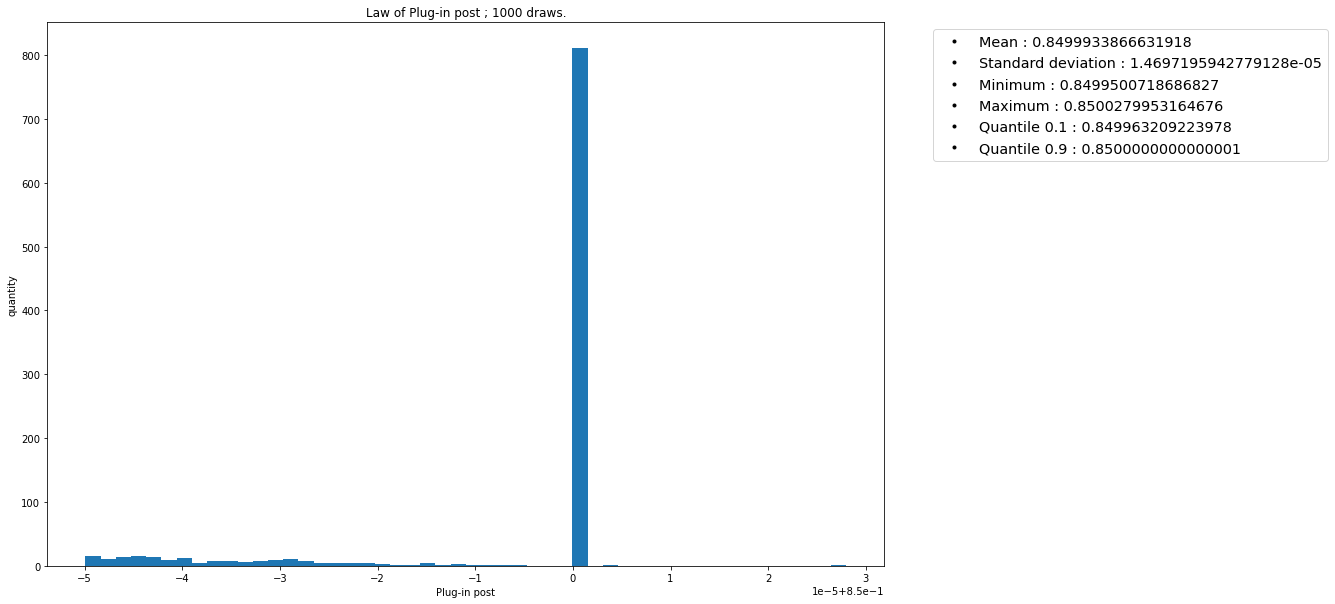

In [33]:
get_law(plug_in_post[:, 0], bins = 50, name = 'Plug-in post', law = None, name_law = '', savefig = '')

In [34]:
def met_hast_bays(n_sample, n_trial): 
    degree = hosp_true.shape[0] * np.ones(5)
    degree[0] = dr_true.shape[0]
    result = np.zeros((n_sample, 15))
    def compute_sqe(x, sigma = np.ones(5)):
        dr_pred, hosp_pred = get_pred(x)
        #sigma_sq = compute_sigma_sq(dr_pred, hosp_pred, dr_true, hosp_true)
        sqe = squared_error(dr_pred, hosp_pred, dr_true, hosp_true, weight = sigma*sigma)
        return sqe
    
    def step_sampling(x, sqe, sigma):
        x_new = x.copy()
        x_new[0:1] = draw_input_params()[0:1]#x[0:1] + 0.1*(bound[1][0] - bound[0][0])*np.random.randn(1)
        if np.all(x_new >= bound[0]) and np.all(x_new <= bound[1]):
            dr_pred, hosp_pred = get_pred(x_new)
            
            sigma_new = np.sqrt(compute_sigma_sq(dr_pred, hosp_pred, dr_true, hosp_true))
            sqe_new = compute_sqe(x_new, sigma_new)

            ro = min(0, np.sum(np.log(sigma / sigma_new)*(0.5*degree - 1)))
            q = np.random.rand(1)
            if np.log(q) <= ro:
                return x_new, sqe_new, sigma_new
            else:
                return x, sqe, sigma
        else:
            return x, sqe, sigma
        
    x = 0.25*bound[0] + 0.75*bound[1]
    print(x)
    dr_pred, hosp_pred = get_pred(x)
    sigma = np.sqrt(compute_sigma_sq(dr_pred, hosp_pred, dr_true, hosp_true))
    sqe = compute_sqe(x, sigma)
    
    for i in range(n_trial):
        x, sqe, sigma = step_sampling(x, sqe, sigma)
         
    result[0] = x
    for i in range(1, n_sample):
        result[i], sqe, sigma = step_sampling(x, sqe, sigma)
            
    return result    
    

In [35]:
result_bays = met_hast_bays(1000, 1)

[7.750e-01 1.625e-01 3.250e-02 1.750e-01 1.750e-01 3.500e-01 1.100e+01
 2.250e+01 1.750e+01 3.275e+00 6.250e-02 4.675e+01 2.325e+01 7.525e+01
 7.750e-04]


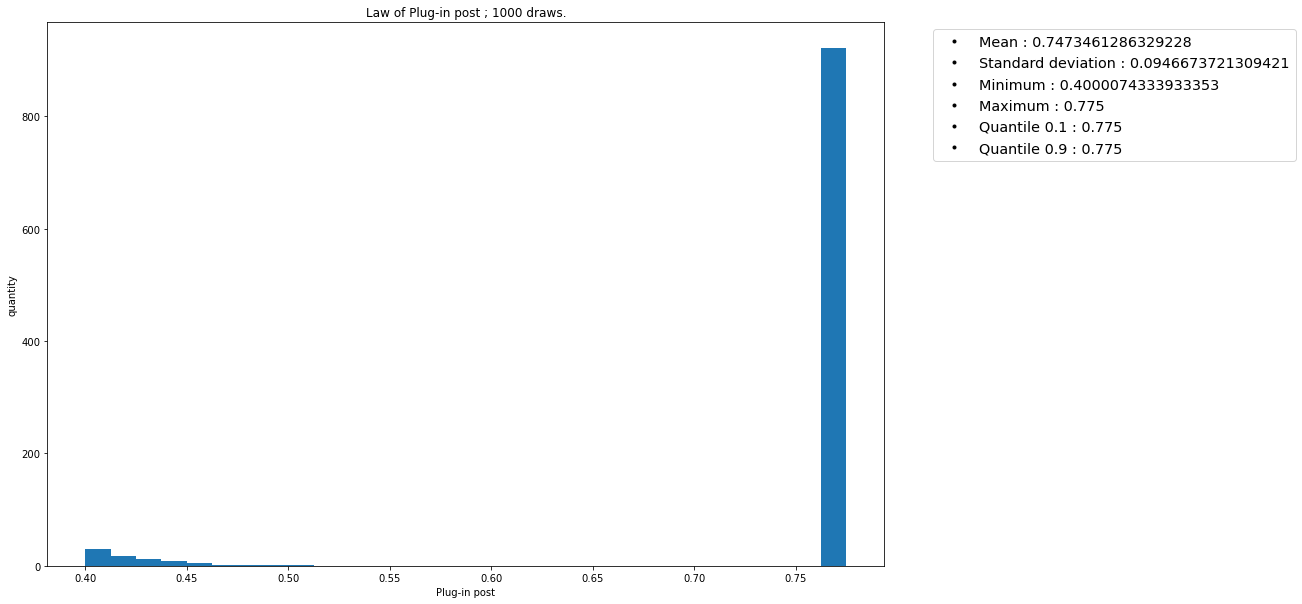

In [36]:
get_law(result_bays[:, 0], bins = 30, name = 'Plug-in post', law = None, name_law = '', savefig = '')

### Q10

In [37]:
dr_true_avma = data_dr['nbre'].values[(dt.datetime(2020, 4, 1) - dt.datetime(2020, 2, 25)).days :\
                                  (dt.datetime(2020, 5, 11) - dt.datetime(2020, 2, 25)).days + 1]
hosp_true_avma = data_hosp[['H', 'U', 'R', 'D']].values[(dt.datetime(2020, 4, 1) - dt.datetime(2020, 3, 18)).days :\
                                                    (dt.datetime(2020, 5, 11) - dt.datetime(2020, 3, 18)).days + 1]

In [38]:
dr_pred_avma, hosp_pred_avma = get_pred(res.x, dt.datetime(2020, 5, 11))
dr_pred_avma = dr_pred_avma[(dt.datetime(2020, 4, 1) - dt.datetime(2020, 1, 25)).days - int(res.x[-3]) : ]
hosp_pred_avma = hosp_pred_avma[(dt.datetime(2020, 4, 1) - dt.datetime(2020, 1, 25)).days - int(res.x[-3]) : ]

In [39]:
plot_data(dr_true_avma, hosp_true_avma, dr_pred_avma, hosp_pred_avma)